<a href="https://colab.research.google.com/github/appersaravanan/public_images/blob/main/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from collections import defaultdict
import math
import networkx as nx
import random
from tqdm import tqdm
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import gzip as gzip_lib
import numpy as np
import os
import pprint
import shutil
import tempfile
import urllib
import uuid

In [2]:
!git clone https://github.com/appersaravanan/public_images.git

Cloning into 'public_images'...
remote: Enumerating objects: 2602, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 2602 (delta 14), reused 39 (delta 11), pack-reused 2556
Receiving objects: 100% (2602/2602), 284.24 MiB | 38.84 MiB/s, done.
Resolving deltas: 100% (78/78), done.
Updating files: 100% (5050/5050), done.


In [18]:
#movies = pd.read_csv("/content/public_images/interim/000.csv",on_bad_lines='skip')

filenames= os.listdir("/content/sample_data/bills_file/interim")


In [14]:
!mv  /content/public_images/interim/ /content/sample_data/bills_file/

In [32]:
len(filenames)
base_path="/content/sample_data/bills_file/interim/"
files =[_ for _ in filenames if int(_.split(".")[0]) > 100]
sentences=[]
for filename in files:
  path="{}{}".format(base_path,filename)
  df=pd.read_csv(path,on_bad_lines='skip')
  for line in df["8"]:
    sentences.append(line)
sentences;


In [34]:
len(sentences)

28342

In [21]:
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=1000, # number of words in vocabulary
                                    output_sequence_length=55) 

In [ ]:
def make_mlp_sequential_model(hparams):
  """Creates a sequential multi-layer perceptron model."""
  model = tf.keras.Sequential()
  model.add(
      tf.keras.layers.InputLayer(
          input_shape=(hparams.max_seq_length,), name='words'))
  # Input is already one-hot encoded in the integer format. We cast it to
  # floating point format here.
  model.add(
      tf.keras.layers.Lambda(lambda x: tf.keras.backend.cast(x, tf.float32)))
  for num_units in hparams.num_fc_units:
    model.add(tf.keras.layers.Dense(num_units, activation='relu'))
    # For sequential models, by default, Keras ensures that the 'dropout' layer
    # is invoked only during training.
    model.add(tf.keras.layers.Dropout(hparams.dropout_rate))
  model.add(tf.keras.layers.Dense(hparams.num_classes))
  return model

In [ ]:
def _dict_to_example(instance):
  """Decoded CSV to tf example."""
  feature = {}
  for key, value in instance.items():
    if value is None:
      feature[key] = tf.train.Feature()
    elif value.dtype == np.integer:
      feature[key] = tf.train.Feature(
          int64_list=tf.train.Int64List(value=value.tolist()))
    elif value.dtype == np.float32:
      feature[key] = tf.train.Feature(
          float_list=tf.train.FloatList(value=value.tolist()))
    else:
      feature[key] = tf.train.Feature(
          bytes_list=tf.train.BytesList(value=value.tolist()))
  return tf.train.Example(features=tf.train.Features(feature=feature))


examples_path = tempfile.mkdtemp(prefix="tfx-data")
train_path = os.path.join(examples_path, "train.tfrecord")
eval_path = os.path.join(examples_path, "eval.tfrecord")

for path, dataset in [(train_path, train_set), (eval_path, eval_set)]:
  with tf.io.TFRecordWriter(path) as writer:
    for example in dataset:
      writer.write(
          _dict_to_example({
              "label": np.array([example["label"].numpy()]),
              "text": np.array([example["text"].numpy()]),
          }).SerializeToString())

In [ ]:
def create_embeddings(train_path, output_path):
  dataset = create_dataset(train_path)
  embeddings_path = os.path.join(output_path, 'embeddings.tfr')

  feature_map = {
      'label': tf.io.FixedLenFeature([], tf.int64),
      'id': tf.io.VarLenFeature(tf.string),
      'text': tf.io.VarLenFeature(tf.string)
  }

  with tf.io.TFRecordWriter(embeddings_path) as writer:
    for tfrecord in dataset:
      tensor_dict = tf.io.parse_single_example(tfrecord, feature_map)
      embedding_example = create_embedding_example(tensor_dict)
      writer.write(embedding_example.SerializeToString())


In [ ]:


def tf_data_generator(file_list, batch_size = 20):
    i = 0
    while True:
        if i*batch_size >= len(file_list):  
            i = 0
            np.random.shuffle(file_list)
        else:
            file_chunk = file_list[i*batch_size:(i+1)*batch_size] 
            data = []
            labels = []
            label_classes = tf.constant(["Fault_1", "Fault_2", "Fault_3", "Fault_4", "Fault_5"]) # This line has changed.
            for file in file_chunk:
                temp = pd.read_csv(open(file,'r'))
                data.append(temp.values.reshape(32,32,1)) 
                pattern = tf.constant(eval("file[14:21]"))  # This line has changed
                for j in range(len(label_classes)):
                    if re.match(pattern.numpy(), label_classes[j].numpy()):  # This line has changed.
                        labels.append(j)
            data = np.asarray(data).reshape(-1,32,32,1)
            labels = np.asarray(labels)
            yield data, labels
            i = i + 1

In [ ]:
def tf_data_generator(file_list, batch_size = 20):
    i = 0
    while True:
        if i*batch_size >= len(file_list):  
            i = 0
            np.random.shuffle(file_list)
        else:
            file_chunk = file_list[i*batch_size:(i+1)*batch_size] 
            data = []
            labels = []
            label_classes = tf.constant(["Fault_1", "Fault_2", "Fault_3", "Fault_4", "Fault_5"]) # This line has changed.
            for file in file_chunk:
                temp = pd.read_csv(open(file,'r'))
                data.append(temp.values.reshape(32,32,1)) 
                pattern = tf.constant(eval("file[14:21]"))  # This line has changed
                for j in range(len(label_classes)):
                    if re.match(pattern.numpy(), label_classes[j].numpy()):  # This line has changed.
                        labels.append(j)
            data = np.asarray(data).reshape(-1,32,32,1)
            labels = np.asarray(labels)
            yield data, labels
            i = i + 1

In [ ]:
def create_model(vocabulary_size, embedding_dim):

    inputs = {
        "target": layers.Input(name="target", shape=(), dtype="int32"),
        "context": layers.Input(name="context", shape=(), dtype="int32"),
    }
    # Initialize item embeddings.
    embed_item = layers.Embedding(
        input_dim=vocabulary_size,
        output_dim=embedding_dim,
        embeddings_initializer="he_normal",
        embeddings_regularizer=keras.regularizers.l2(1e-6),
        name="item_embeddings",
    )
    # Lookup embeddings for target.
    target_embeddings = embed_item(inputs["target"])
    # Lookup embeddings for context.
    context_embeddings = embed_item(inputs["context"])
    # Compute dot similarity between target and context embeddings.
    logits = layers.Dot(axes=1, normalize=False, name="dot_similarity")(
        [target_embeddings, context_embeddings]
    )
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

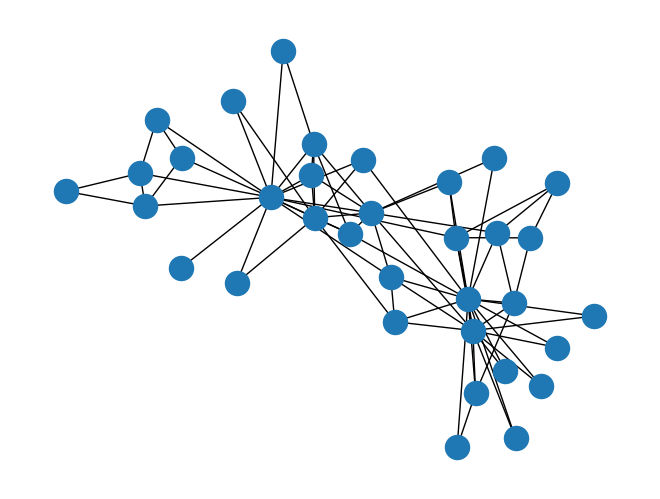

In [9]:
import networkx as nx
G = nx.karate_club_graph()
nx.draw(G)